<a href="https://colab.research.google.com/github/UTLogicLabs/D213-TimeSeries/blob/main/D213_Task_1_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Appropriate Libraries

In [44]:
!pip install statsmodels
!pip install pmdarima

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm

from pandas import DataFrame
from datetime import datetime
from pmdarima import auto_arima

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from google.colab import output
output.no_vertical_scroll()

<IPython.core.display.Javascript object>

## Data Acquistion

In [3]:
df = pd.read_csv('/content/teleco_time_series.csv')

## Clean/Explore the Data

In [4]:
df.shape

(731, 2)

In [5]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [6]:
df.shape

(731, 2)

In [7]:
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [8]:
df.dtypes

Day          int64
Revenue    float64
dtype: object

In [9]:
df.isnull().sum()

Day        0
Revenue    0
dtype: int64

In [10]:
df['Date'] = (pd.date_range(start=datetime(2022, 1, 1), periods=df.shape[0], freq='24H'))
df.set_index('Date', inplace=True)
df.drop(columns=['Day'], inplace=True)
df

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,0.000793
2022-01-03,0.825542
2022-01-04,0.320332
2022-01-05,1.082554
...,...
2023-12-28,16.931559
2023-12-29,17.490666
2023-12-30,16.803638


## Visualize the Data

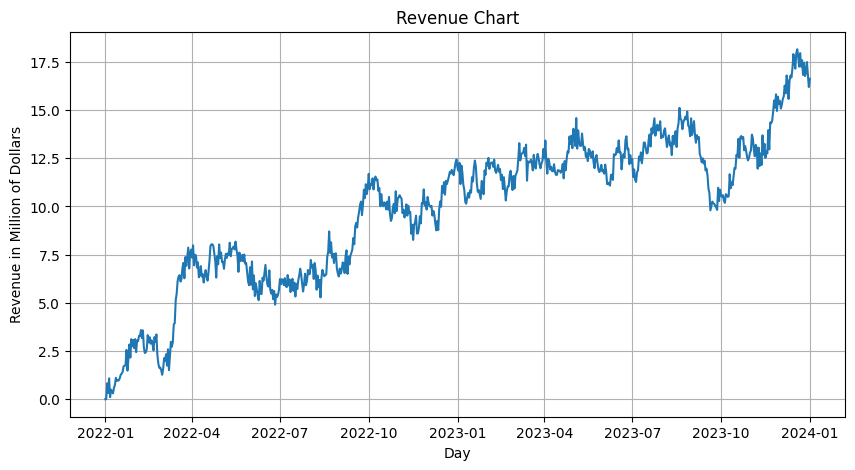

In [11]:
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in Million of Dollars')
plt.grid(True)
plt.show()

In [12]:
rolling_mean = df.Revenue.rolling(window=12).mean()
rolling_std = df.Revenue.rolling(window=12).std()

rolling_mean, rolling_std

(Date
 2022-01-01          NaN
 2022-01-02          NaN
 2022-01-03          NaN
 2022-01-04          NaN
 2022-01-05          NaN
                 ...    
 2023-12-28    17.419551
 2023-12-29    17.448285
 2023-12-30    17.352852
 2023-12-31    17.189523
 2024-01-01    17.093854
 Name: Revenue, Length: 731, dtype: float64,
 Date
 2022-01-01         NaN
 2022-01-02         NaN
 2022-01-03         NaN
 2022-01-04         NaN
 2022-01-05         NaN
                 ...   
 2023-12-28    0.468451
 2023-12-29    0.460647
 2023-12-30    0.466114
 2023-12-31    0.501611
 2024-01-01    0.490434
 Name: Revenue, Length: 731, dtype: float64)

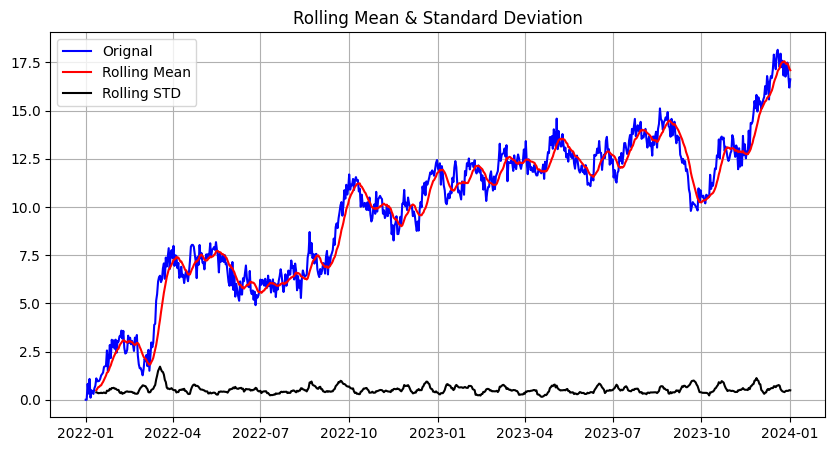

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df.Revenue, color='blue', label='Orignal')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.show(block=False)

## Run ADF or KPSS to check for Stationarity

In [14]:
def ad_test(dataset):
  results = adfuller(dataset)
  print(f'1. ADF : {round(results[0], 2)}')
  print(f'2. P-Value : {results[1]}')
  print(f'3. Number of Lags : {(results[2])}')
  print(f'4. Number of observations used for ADF Regression and Critical Values Calculations : {results[3]}')
  print('5. Critical Values:')
  for key, value in results[4].items():
    print(f'\t{key} : {round(value, 2)}')

  if results[1] <= 0.05:
    print("\nReject NULL Hypothesis, the time series is stationary.")
  else:
    print("\nAccept NULL Hypothesis, the time series is non-stationary.")


ad_test(df.Revenue)

1. ADF : -1.92
2. P-Value : 0.3205728150793977
3. Number of Lags : 1
4. Number of observations used for ADF Regression and Critical Values Calculations : 729
5. Critical Values:
	1% : -3.44
	5% : -2.87
	10% : -2.57

Accept NULL Hypothesis, the time series is non-stationary.


In [15]:
stationary_df = df.diff().dropna()
stationary_df.head()

,Revenue
Date,
2022-01-02,0.000793
2022-01-03,0.824749
2022-01-04,-0.505210
2022-01-05,0.762222
2022-01-06,-0.974900


In [16]:
ad_test(stationary_df.Revenue)

1. ADF : -44.87
2. P-Value : 0.0
3. Number of Lags : 0
4. Number of observations used for ADF Regression and Critical Values Calculations : 729
5. Critical Values:
	1% : -3.44
	5% : -2.87
	10% : -2.57

Reject NULL Hypothesis, the time series is stationary.


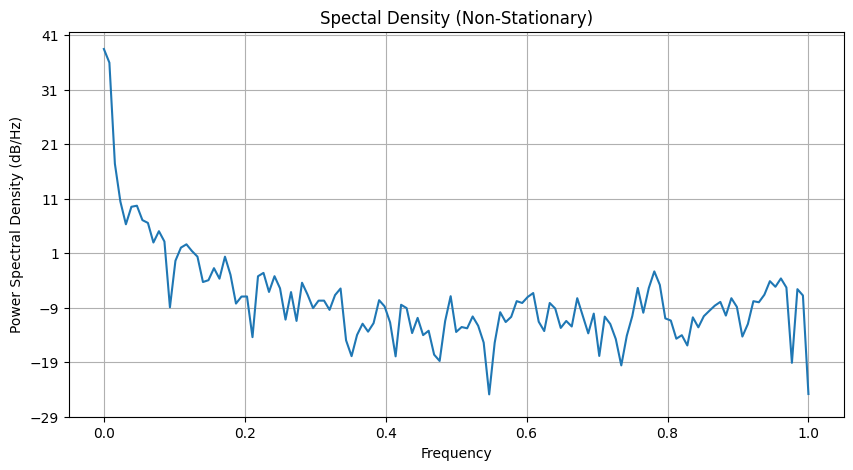

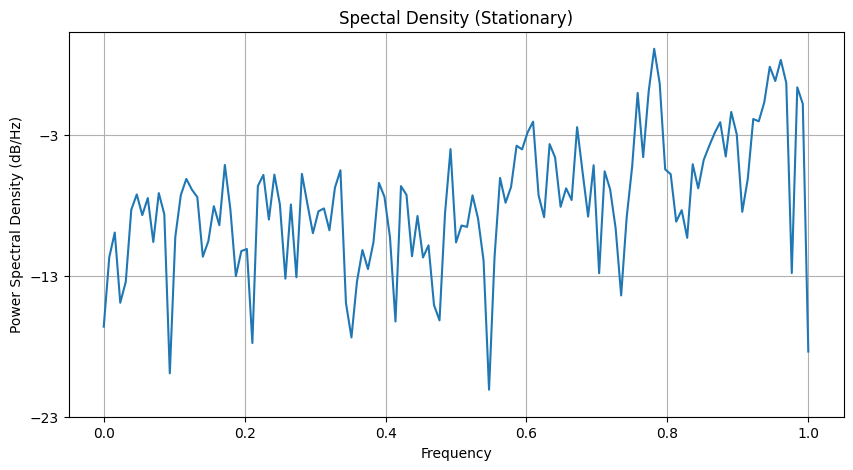

In [17]:
plt.figure(figsize=(10,5), linewidth=3)
plt.psd(df.Revenue)
plt.title('Spectal Density (Non-Stationary)')
plt.show()

plt.figure(figsize=(10,5), linewidth=3)
plt.psd(stationary_df.Revenue)
plt.title('Spectal Density (Stationary)')
plt.show()

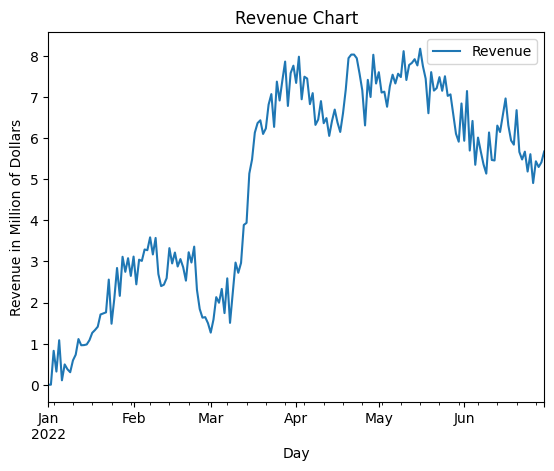

In [18]:
# 2019, 1, 1
df.loc[:'2022-06-30'].plot()
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in Million of Dollars')
plt.show()

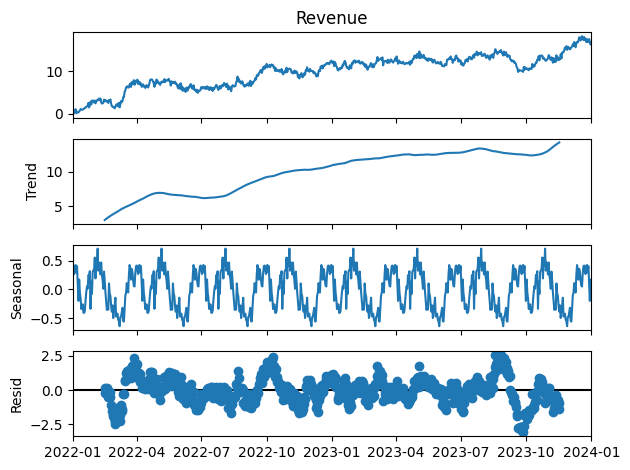

In [19]:
decomp = seasonal_decompose(df.Revenue, period=90)
decomp.plot()
plt.show()

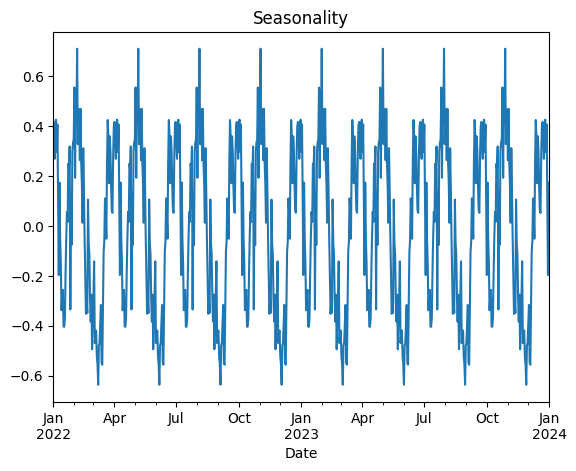

In [20]:
plt.title('Seasonality')
decomp.seasonal.plot()
plt.show()

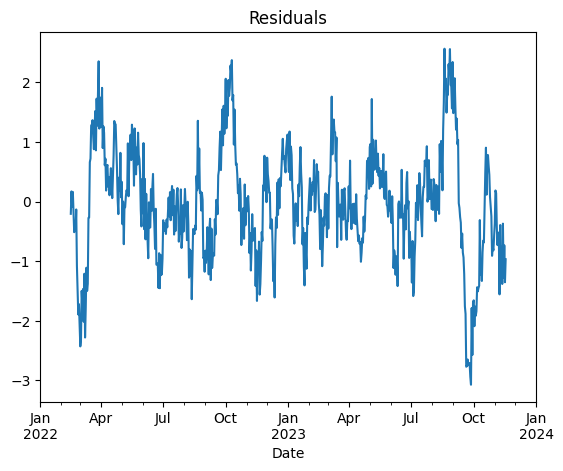

In [21]:
plt.title('Residuals');
decomp.resid.plot()
plt.show()

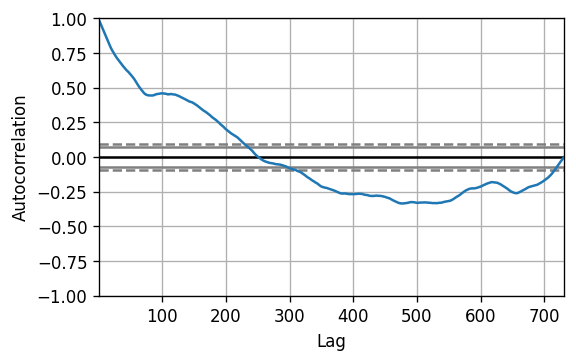

In [22]:
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi': 120})
autocorrelation_plot(df.Revenue.tolist())
plt.show()

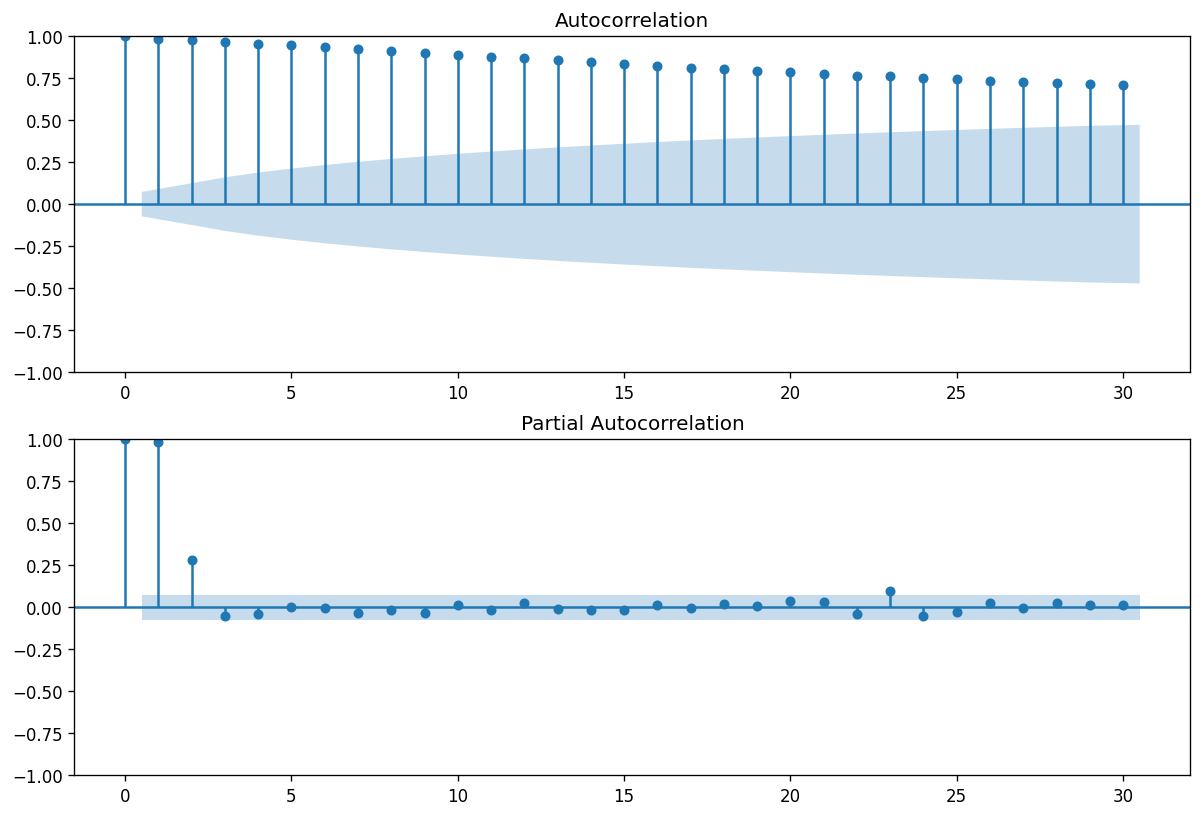

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.Revenue, lags=30, ax=ax1);

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.Revenue, lags=30, ax=ax2);
plt.show()

<Figure size 1440x960 with 0 Axes>

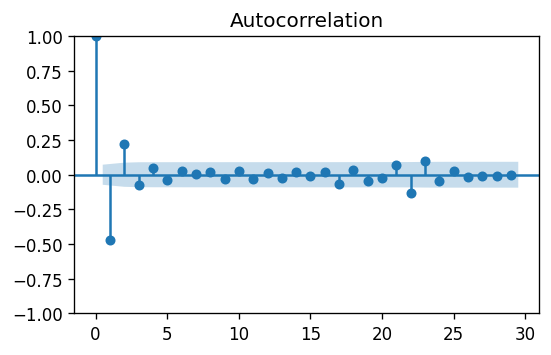

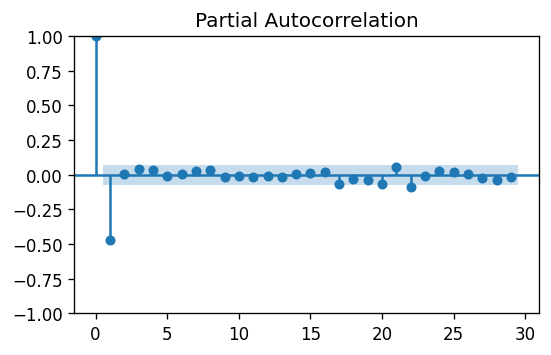

In [24]:
fig = plt.figure(figsize=(12,8))
plot_acf(stationary_df)
plot_pacf(stationary_df)
plt.show()

## Save Cleaned Data

In [25]:
X_train, X_test = train_test_split(df, test_size=0.20, random_state=42, shuffle=False)
print(df.shape)
print(X_train.shape, X_test.shape)

(731, 1)
(584, 1) (147, 1)


In [26]:
df.to_csv('cleaned_data.csv')
X_train.to_csv('training_data.csv')
X_test.to_csv('testing_data.csv')

## PArt IV: Model Identification & Analysis

### Perform Auto and Manual ARIMA

In [27]:
model_1 = auto_arima(df.Revenue, trace=True)
model_1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.192 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Tue, 02 Jul 2024   AIC                            983.122
Time:                        04:58:39   BIC                            996.901
Sample:                    01-01-2022   HQIC                           988.438
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model_m = ARIMA(df.Revenue, order=(1, 1, 0))
model_m =model_m.fit()
model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Tue, 02 Jul 2024   AIC                            984.710
Time:                        04:58:39   BIC                            993.896
Sample:                    01-01-2022   HQIC                           988.254
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.98   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
model_m = ARIMA(df.Revenue, order=(1, 0, 0))
model_m =model_m.fit()
model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -582.531
Date:                Tue, 02 Jul 2024   AIC                           1171.061
Time:                        04:58:39   BIC                           1184.844
Sample:                    01-01-2022   HQIC                          1176.379
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4634      2.606      3.632      0.000       4.357      14.570
ar.L1          0.9945      0.004    243.683      0.000       0.986       1.002
sigma2         0.2864      0.016     17.783      0.000       0.255       0.318
===================================================================================
Ljung-Box (L1) (Q):                 159.77   Jarque-Bera (JB):                 2.13
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.02   Skew:                            -0.03
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_m = ARIMA(df.Revenue, order=(1, 0, 1))
model_m =model_m.fit()
model_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -512.076
Date:                Tue, 02 Jul 2024   AIC                           1032.152
Time:                        04:58:40   BIC                           1050.530
Sample:                    01-01-2022   HQIC                          1039.242
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7254      5.720      1.525      0.127      -2.486      19.937
ar.L1          0.9990      0.002    412.339      0.000       0.994       1.004
ma.L1         -0.3845      0.033    -11.512      0.000      -0.450      -0.319
sigma2         0.2359      0.013     17.836      0.000       0.210       0.262
===================================================================================
Ljung-Box (L1) (Q):                   6.62   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.01   Prob(JB):                         0.39
Heteroskedasticity (H):               1.00   Skew:                             0.01
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model_t1=auto_arima(X_train.Revenue, trace=True)
model_t1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=776.988, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=910.148, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.046, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=798.905, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.276, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.043, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.043, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=776.811, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=774.035, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.834 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -383.523
Date:                Tue, 02 Jul 2024   AIC                            773.046
Time:                        04:58:40   BIC                            786.151
Sample:                    01-01-2022   HQIC                           778.154
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0335      0.019      1.720      0.085      -0.005       0.072
ar.L1         -0.4605      0.036    -12.663      0.000      -0.532      -0.389
sigma2         0.2181      0.014     16.020      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.96   Prob(JB):                         0.41
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_tm = ARIMA(X_train.Revenue, order=(1, 0, 0))
model_tm =model_tm.fit()
model_tm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -455.889
Date:                Tue, 02 Jul 2024   AIC                            917.779
Time:                        04:58:41   BIC                            930.888
Sample:                    01-01-2022   HQIC                           922.888
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3706      2.278      3.675      0.000       3.906      12.835
ar.L1          0.9931      0.005    202.085      0.000       0.983       1.003
sigma2         0.2769      0.017     16.056      0.000       0.243       0.311
===================================================================================
Ljung-Box (L1) (Q):                 123.09   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               0.94   Skew:                            -0.12
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model_test_1=auto_arima(X_test.Revenue, trace=True)
model_test_1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=218.654, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=254.431, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=214.489, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.069, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=252.612, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=216.267, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=216.240, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=216.739, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=213.048, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=214.777, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=214.748, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=223.742, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=215.260, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.604 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -104.524
Date:                Tue, 02 Jul 2024   AIC                            213.048
Time:                        04:58:41   BIC                            219.016
Sample:                    08-08-2023   HQIC                           215.473
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4982      0.077     -6.434      0.000      -0.650      -0.346
sigma2         0.2446      0.031      7.810      0.000       0.183       0.306
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.83   Prob(JB):                         0.51
Heteroskedasticity (H):               1.23   Skew:                             0.16
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
model_test_m = ARIMA(X_test.Revenue, order=(1, 0, 0))
model_test_m = model_test_m.fit()
model_test_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  147
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -126.118
Date:                Tue, 02 Jul 2024   AIC                            258.236
Time:                        04:58:41   BIC                            267.207
Sample:                    08-08-2023   HQIC                           261.881
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0531      1.361     10.322      0.000      11.385      16.721
ar.L1          0.9646      0.022     42.991      0.000       0.921       1.009
sigma2         0.3198      0.045      7.062      0.000       0.231       0.409
===================================================================================
Ljung-Box (L1) (Q):                  32.02   Jarque-Bera (JB):                 3.66
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.54   Skew:                             0.26
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model = SARIMAX(df, order=(1,1,0), seasonal_order=(1,1,0,90))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -556.973
Date:                            Tue, 02 Jul 2024   AIC                           1119.946
Time:                                    04:59:10   BIC                           1133.330
Sample:                                01-01-2022   HQIC                          1125.141
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4948      0.035    -14.031      0.000      -0.564      -0.426
ar.S.L90      -0.4702      0.035    -13.415      0.000      -0.539      -0.402
sigma2         0.3221      0.017     18.791      0.000       0.288       0.356
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.65   Prob(JB):                         0.25
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
forcast = results.forecast(90)
predictions_df = forcast.to_frame()
# predictions_df.columns = ['Revenue']
forcast

2024-01-02    16.494644
2024-01-03    16.586656
2024-01-04    17.106266
2024-01-05    17.016519
2024-01-06    17.146204
                ...    
2024-03-27    19.373410
2024-03-28    19.948791
2024-03-29    19.448847
2024-03-30    19.089727
2024-03-31    19.352887
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [37]:
predictions = results.predict(-90)
predictions

2023-10-04    10.557022
2023-10-05    10.613631
2023-10-06    10.578464
2023-10-07    10.443797
2023-10-08    10.945937
                ...    
2023-12-28    17.045438
2023-12-29    16.587561
2023-12-30    17.181132
2023-12-31    16.865131
2024-01-01    16.338846
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [38]:
mae = np.mean(np.abs(results.resid))
print(f'Mean Absolute Error: { round(mae, 2) }')

Mean Absolute Error: 0.46


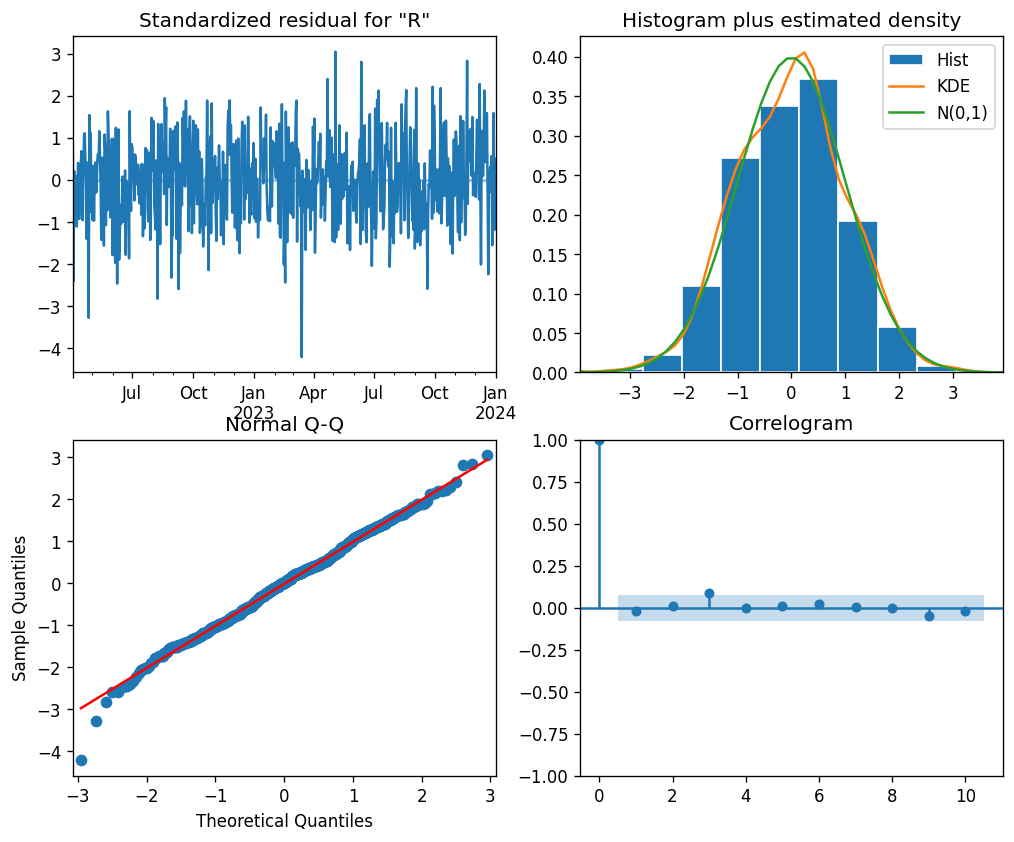

In [39]:
results.plot_diagnostics(figsize=[10,8])
plt.show()

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -556.973
Date:                            Tue, 02 Jul 2024   AIC                           1119.946
Time:                                    04:59:11   BIC                           1133.330
Sample:                                01-01-2022   HQIC                          1125.141
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4948      0.035    -14.031      0.000      -0.564      -0.426
ar.S.L90      -0.4702      0.035    -13.415      0.000      -0.539      -0.402
sigma2         0.3221      0.017     18.791      0.000       0.288       0.356
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.65   Prob(JB):                         0.25
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
df['predicted_revenue'] = predictions
print(r2_score(df['Revenue'].tail(90), df['predicted_revenue'].tail(90)))

0.932803243624546


In [42]:
prediction = results.get_prediction(start=len(df.index)+1, end=len(df.index) + 90)
mean_prediction = prediction.predicted_mean
confidence_intervals = prediction.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

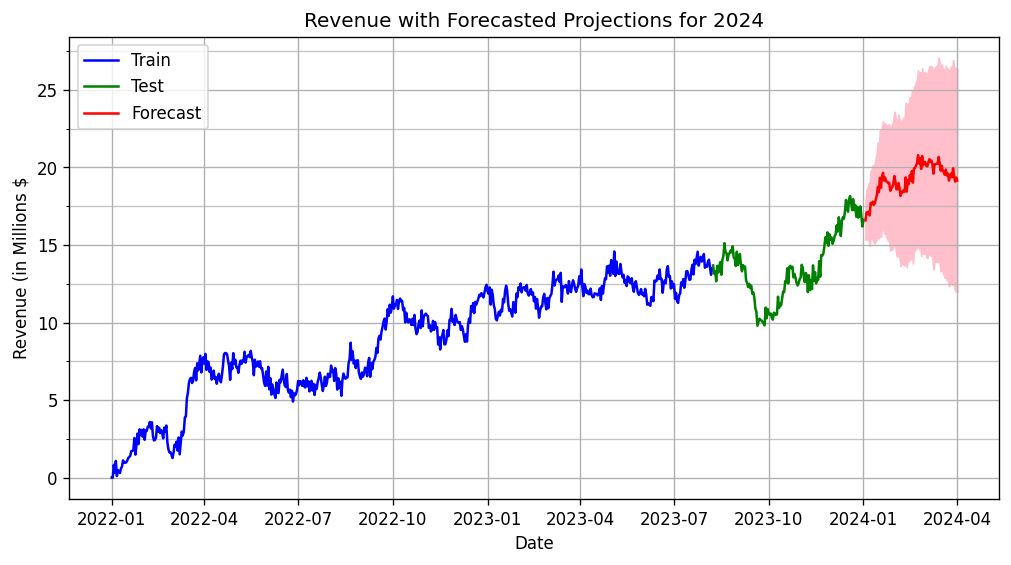

In [43]:
plt.figure(figsize=(10,5))
plt.plot(X_train.index, X_train, label='Train', color='b')
plt.plot(X_test.index, X_test, label='Test', color='g')
plt.plot(mean_prediction.index, mean_prediction, color='r', label='Forecast')
plt.fill_between(lower_limits.index, upper_limits, lower_limits, color='pink')
plt.title('Revenue with Forecasted Projections for 2024')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions $')
plt.xticks(rotation=45, minor=True)
plt.yticks(np.arange(0, 30, 2.5), minor=True)
plt.grid(which='major', alpha=1)
plt.grid(which='minor', alpha=0.75)
plt.legend(loc='upper left')
plt.show()